# Notebook to extract the max of Specific heat

In [2]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
from isingchat import style
from isingchat.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


p-1.1_nv-26_h-0.yml
C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\venv\data\regular\infinite-size\centrosym\IFUNAM_upload\IFUNAM_upload\p_1.1\p-1.1_nv-26_h-0.free-energy.h5
C_V max.: 1.2776728
Temp. at C_V max.: 4.8489032


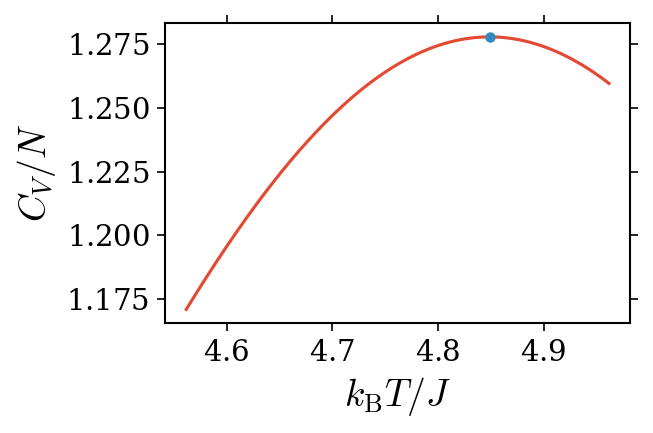

p-1.1_nv-27_h-0.yml
C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\venv\data\regular\infinite-size\centrosym\IFUNAM_upload\IFUNAM_upload\p_1.1\p-1.1_nv-27_h-0.free-energy.h5
C_V max.: 1.2891155
Temp. at C_V max.: 4.909087


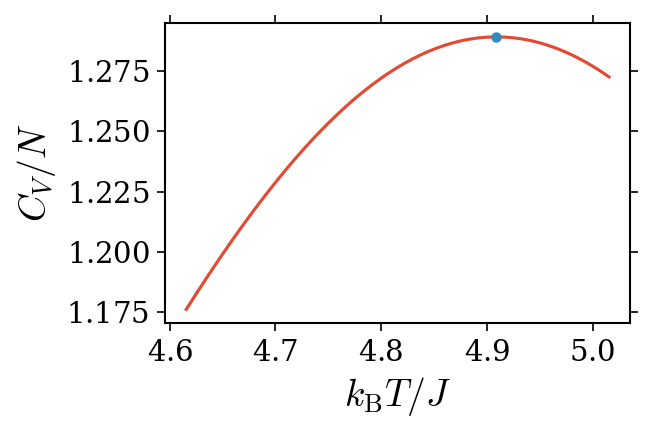

p-1.1_nv-28_h-0.yml
C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\venv\data\regular\infinite-size\centrosym\IFUNAM_upload\IFUNAM_upload\p_1.1\p-1.1_nv-28_h-0.free-energy.h5
C_V max.: 1.3000881
Temp. at C_V max.: 4.9672576


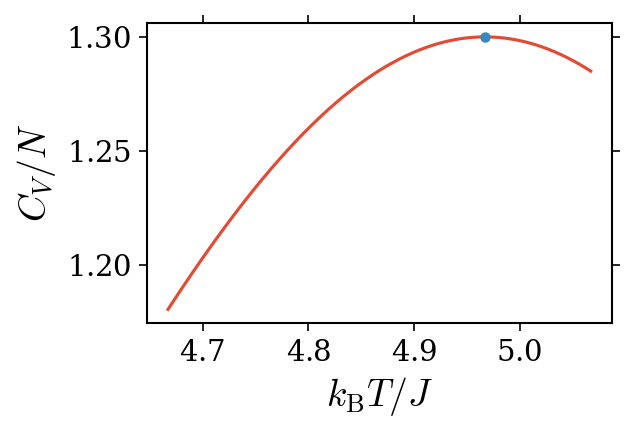

p-1.1_nv-30_h-0.yml
C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\venv\data\regular\infinite-size\centrosym\IFUNAM_upload\IFUNAM_upload\p_1.1\p-1.1_nv-30_h-0.free-energy.h5
C_V max.: 1.3207566
Temp. at C_V max.: 5.0781022


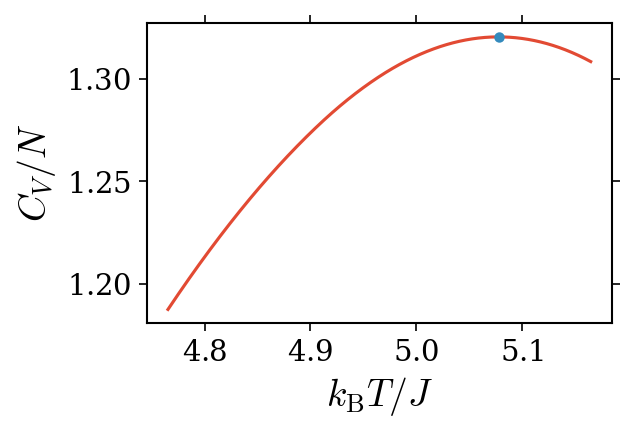

Exporting data to C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\venv\data\regular\infinite-size\centrosym\IFUNAM_upload\IFUNAM_upload\p_1.1\max_cv.csv


In [11]:
list_exp_p = [#     1.0,1.05,
    1.1
#     1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9
]
list_nv = [26,27,28,30]
all_max_cv = {}
for exp_p in list_exp_p:
    all_max_cv[exp_p] = {}
    data_path = Path("../../data/regular/infinite-size/centrosym/IFUNAM_upload/IFUNAM_upload/p_{}".format(exp_p)).resolve()
    all_files = os.listdir(data_path)
    for nv in list_nv:
        try:
            file = 'p-{}_nv-{}_h-0.yml'.format(exp_p,nv)
            config_file = Path(os.path.join(data_path,file)).resolve()
            energy_file = config_file.with_suffix(".free-energy.h5")
            print(file)
            print(energy_file)

            with config_file.open() as cfp:
                config_info = yaml.load(cfp)
            config_data = read_ising_config(config_info)

            with h5py.File(str(energy_file)) as h5fp:
                data_energy = h5fp["/free-energy"][()]

            temp = config_data["system"]["temperature"]
            mag_field = config_data["system"]["magnetic_field"]
            free_erg = data_energy[:, :]

            # Zero magnetic field spline
            free_erg_spl_zmf = interp.UnivariateSpline(temp,
                                                       free_erg[:, 0],
                                                       s=0, k=4)
            temp_fine = np.linspace(temp.min(), temp.max(), 2048)

            # Second derivative of the free energy.
            free_erg_der_spl_zmf = free_erg_spl_zmf.derivative(n=2)
            cv_fine = -temp_fine * free_erg_der_spl_zmf(temp_fine)
            cv_max_idx = np.argmax(cv_fine)
            temp_cv_max, cv_max = temp_fine[cv_max_idx], cv_fine[cv_max_idx]

            print(f"C_V max.: {cv_max:.8G}")
            print(f"Temp. at C_V max.: {temp_cv_max:.8G}")
            all_max_cv[exp_p][nv] = {
                'max_Cv': cv_max,
                'temp_at_max_Cv': temp_cv_max
            }

            use_tex = False

            # Load the default style.
            style.use("default")
            rcParams["text.usetex"] = use_tex

            fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
            grid_spec = GridSpec(3, 1)

            # Specific heat subplot.
            ax: Axes = fig1.add_subplot(grid_spec[0, 0])

            ax.plot(temp_fine, cv_fine, lw=1.5)
            ax.plot(temp_cv_max, cv_max, marker="o", lw=0)

            ax.set_xlabel(r"$k_\mathrm{B} T / J$")
            ax.set_ylabel(r"$C_V / N$")

            pyplot.draw()
            pyplot.show()
            
        except KeyError:
            print('error with this file {}'.format(file))
        except OSError:
            print('there is not file {}'.format(file))
                
    # Export to pandas 
    print('Exporting data to {}'.format(os.path.join(data_path,'max_cv.csv')))
    df = pd.DataFrame(all_max_cv[exp_p])
    df.loc['inv_temp_at_max_Cv'] = 1/df.loc['temp_at_max_Cv']
    df = df.reindex(sorted(df.columns), axis=1)
    df.to_csv(os.path.join(data_path,'exp_p-{}_max_cv.csv'.format(exp_p)))

In [4]:
all_max_cv

{2.0: {2: {'max_Cv': 0.6847892025018129, 'temp_at_max_Cv': 2.975818270639961}}}

In [6]:
df_exp = df.reindex(sorted(df.columns), axis=1)

In [5]:
de_exp

NameError: name 'de_exp' is not defined

In [8]:
df_exp.to_csv(os.path.join(data_path,'alpha-{}_max_cv.csv'.format(alpha)))

### Insert all max_cv to json 

In [27]:
import json
with open("../../../data/all_max_cv.json", "w") as outfile: 
    print('Save {}'.format(outfile.name))
    json.dump(all_max_cv, outfile,indent=4)

Save ../../data/all_max_cv.json


### import to csv

In [4]:
import pandas as pd
df = pd.DataFrame(all_max_cv[1.1])

In [7]:
df.head()

,2,3,4,5,6,7
max_Cv,0.545464,0.636133,0.709688,0.771033,0.823491,0.869223
temp_at_max_Cv,1.469946,1.892921,2.218437,2.485476,2.713532,2.914299
Inv_temp_at_mx_Cv,0.680297,0.528284,0.450768,0.402337,0.368523,0.343136


In [6]:
df.loc['Inv_temp_at_mx_Cv'] = 1/df.loc['temp_at_max_Cv']

In [10]:
df.to_csv('../../../data/alpha_1.1/max_cv.csv')

In [16]:
example_string = "alpha-1.1_nv-2_h-0.yml"
sub_string = re.search('alpha-{}_nv-(.+?)_h-0.yml'.format(1.1), example_string)
if sub_string:
    found = sub_string.group(1)
    print(type(found))


<class 'str'>


In [3]:
import json
# Read all_max_cv.json
with open("../../../data/all_max_cv.json") as json_file:
    all_mx_cv = json.load(json_file)

In [10]:
import os
os.getcwd()
print('{}'.format(alpha))

1.0


### Obtain individual graph

In [3]:
alpha = 1.1
nv = 20
# Read all_max_cv.json
with open("../../../data/all_max_cv.json") as json_file:
    all_max_cv = json.load(json_file)
all_max_cv[alpha] = {}

alpha-1.1_nv-20_h-0_v2.yml
C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\Varios_vecinos\venv\data\alpha_1.1\alpha-1.1_nv-20_h-0_v2.free-energy.h5
C_V max.: 1.1967924
Temp. at C_V max.: 4.4349047


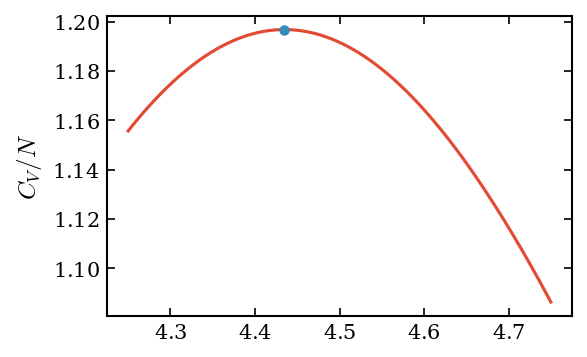

Exporting data to C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\Varios_vecinos\venv\data\alpha_1.1\max_cv.csv


In [5]:
data_path = Path("../../../data/alpha_{}".format(alpha)).resolve()
file = 'alpha-{}_nv-{}_h-0_v2.yml'.format(alpha,nv)

config_file = Path(os.path.join(data_path,file)).resolve()
energy_file = config_file.with_suffix(".free-energy.h5")
print(file)
print(energy_file)

with config_file.open() as cfp:
    config_info = yaml.load(cfp)
config_data = read_ising_config(config_info)

with h5py.File(str(energy_file)) as h5fp:
    data_energy = h5fp["/free-energy"][()]

temp = config_data["system"]["temperature"]
mag_field = config_data["system"]["magnetic_field"]
free_erg = data_energy[:, :]

# Zero magnetic field spline
free_erg_spl_zmf = interp.UnivariateSpline(temp,
                                           free_erg[:, 0],
                                           s=0, k=4)
temp_fine = np.linspace(temp.min(), temp.max(), 2048)

# Second derivative of the free energy.
free_erg_der_spl_zmf = free_erg_spl_zmf.derivative(n=2)
cv_fine = -temp_fine * free_erg_der_spl_zmf(temp_fine)
cv_max_idx = np.argmax(cv_fine)
temp_cv_max, cv_max = temp_fine[cv_max_idx], cv_fine[cv_max_idx]

print(f"C_V max.: {cv_max:.8G}")
print(f"Temp. at C_V max.: {temp_cv_max:.8G}")
all_max_cv[alpha][nv] = {
    'max_Cv': cv_max,
    'temp_at_max_Cv': temp_cv_max
}

use_tex = False

# Load the default style.
style.use("default")
rcParams["text.usetex"] = use_tex

fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

ax.plot(temp_fine, cv_fine, lw=1.5)
ax.plot(temp_cv_max, cv_max, marker="o", lw=0)

# ax.set_xlabel(r"$k_\mathrm{B} T / J$")
ax.set_ylabel(r"$C_V / N$")

pyplot.draw()
pyplot.show()

# Read csv in pandas
try:
    df = pd.read_csv(os.path.join(data_path,'alpha-{}_max_cv.csv'.format(alpha)),index_col=0)
    df.rename(index = {'inv_temp_at_mx_Cv':'inv_temp_at_max_Cv'},inplace=True)
except FileNotFoundError:
    df = pd.DataFrame()
# Export to pandas 
print('Exporting data to {}'.format(os.path.join(data_path,'max_cv.csv')))
insert_data = all_max_cv[alpha][nv]
insert_data['inv_temp_at_max_Cv'] = 1/insert_data['temp_at_max_Cv']
if nv not in df.columns.astype(int):
    df[nv] = pd.Series(insert_data)
    df.to_csv(os.path.join(data_path,'alpha-{}_max_cv.csv'.format(alpha)))


In [5]:
all_max_cv

{'1.1': {'20': {'max_Cv': 1.0864967834346764,
   'temp_at_max_Cv': 4.75,
   'inv_temp_at_max_Cv': 0.21052631578947367}},
 '1.4': {'20': {'max_Cv': 1.0984148116153118,
   'temp_at_max_Cv': 3.05,
   'inv_temp_at_max_Cv': 0.3278688524590164}},
 1.6: {20: {'max_Cv': 1.0164804867918729,
   'temp_at_max_Cv': 2.463898387884709,
   'inv_temp_at_max_Cv': 0.4058608930129273}}}

In [12]:
with config_file.open() as cfp:
    config_info = yaml.load(cfp)
config_data = read_ising_config(config_info)

with h5py.File(str(energy_file)) as h5fp:
    data_energy = h5fp["/free-energy"][()]

temp = config_data["system"]["temperature"]
mag_field = config_data["system"]["magnetic_field"]
free_erg = data_energy[:, :]

print(mag_field)
print(free_erg)

[0.]
[[-1.25      ]
 [-1.25      ]
 [-1.25      ]
 [-1.25      ]
 [-1.25      ]
 [-1.25      ]
 [-1.25      ]
 [-1.25      ]
 [-1.25      ]
 [-1.25      ]
 [-1.25      ]
 [-1.25      ]
 [-1.25      ]
 [-1.25      ]
 [-1.25      ]
 [-1.25      ]
 [-1.25      ]
 [-1.25      ]
 [-1.25      ]
 [-1.25      ]
 [-1.25      ]
 [-1.25000001]
 [-1.25000001]
 [-1.25000003]
 [-1.25000005]
 [-1.25000009]
 [-1.25000016]
 [-1.25000028]
 [-1.25000046]
 [-1.25000073]
 [-1.25000113]
 [-1.25000171]
 [-1.25000252]
 [-1.25000363]
 [-1.25000514]
 [-1.25000714]
 [-1.25000974]
 [-1.2500131 ]
 [-1.25001736]
 [-1.25002269]
 [-1.25002931]
 [-1.25003742]
 [-1.25004727]
 [-1.25005912]
 [-1.25007325]
 [-1.25008997]
 [-1.2501096 ]
 [-1.2501325 ]
 [-1.25015902]
 [-1.25018955]
 [-1.2502245 ]
 [-1.2502643 ]
 [-1.25030937]
 [-1.25036017]
 [-1.25041717]
 [-1.25048085]
 [-1.25055171]
 [-1.25063025]
 [-1.25071698]
 [-1.25081242]
 [-1.25091711]
 [-1.25103158]
 [-1.25115638]
 [-1.25129204]
 [-1.25143912]
 [-1.25159817]
 [-1.

### Get Specific heat

In [15]:
# Zero magnetic field spline
free_erg_spl_zmf = interp.UnivariateSpline(temp,
                                           free_erg[:, 0],
                                           s=0, k=4)
temp_fine = np.linspace(temp.min(), temp.max(), 2048)

# Second derivative of the free energy.
free_erg_der_spl_zmf = free_erg_spl_zmf.derivative(n=2)
cv_fine = -temp_fine * free_erg_der_spl_zmf(temp_fine)
cv_max_idx = np.argmax(cv_fine)
temp_cv_max, cv_max = temp_fine[cv_max_idx], cv_fine[cv_max_idx]

print(f"C_V max.: {cv_max:.8G}")
print(f"Temp. at C_V max.: {temp_cv_max:.8G}")


C_V max.: 0.50547844
Temp. at C_V max.: 1.1951099


### Plots

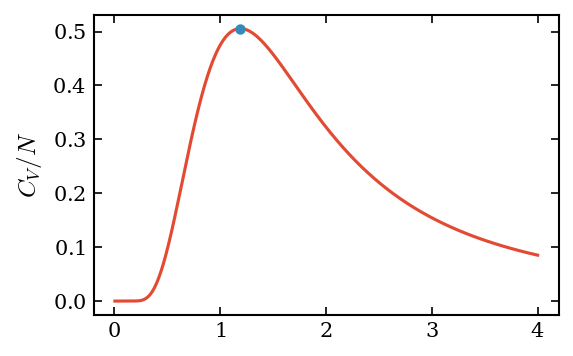

In [16]:
use_tex = False

# Load the default style.
style.use("default")
rcParams["text.usetex"] = use_tex

fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

ax.plot(temp_fine, cv_fine, lw=1.5)
ax.plot(temp_cv_max, cv_max, marker="o", lw=0)

# ax.set_xlabel(r"$k_\mathrm{B} T / J$")
ax.set_ylabel(r"$C_V / N$")

pyplot.draw()
pyplot.show()


In [4]:
1/np.arange(1,26,1)

array([1.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
       0.16666667, 0.14285714, 0.125     , 0.11111111, 0.1       ,
       0.09090909, 0.08333333, 0.07692308, 0.07142857, 0.06666667,
       0.0625    , 0.05882353, 0.05555556, 0.05263158, 0.05      ,
       0.04761905, 0.04545455, 0.04347826, 0.04166667, 0.04      ])